# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Model 4

**Target:**

Stable model test accuracy to be > 99.4% over >7  Epochs.
Result Retained at Last Epoch also.

**Results:**
1. Parameters: **7774**
2. Best Train Accuracy: **99.41%**
3. Best Test Accuracy: **99.44%**

**Analysis:**
1. Model Architecture is tuned with less Filter size to reduce  not only total Parameter also we can manage 28*28 image with less filters
2. Learning Rate is Tuned with STepLR to acheive better consistent accuracy
3. Augmentation is used like Color Jitter Random Rotaion for **+/-5%** and Normalization
4. Best part of Model 1 is : Least gap and Costinency is observed between train and test accuracy 
5. Loss Covergence is Quite good

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.11MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 120kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 923kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             120
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR
import math
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9,nesterov=True,
                         weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
#scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, epochs=15, steps_per_epoch=len(train_loader))
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 1


Loss=0.10382454842329025 Batch_id=468 Accuracy=93.60: 100%|██████████| 469/469 [00:06<00:00, 72.35it/s]  



Test set: Average loss: 0.0562, Accuracy: 9836/10000 (98.36%)

EPOCH: 2


Loss=0.013904877007007599 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:06<00:00, 72.64it/s] 



Test set: Average loss: 0.0421, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.06856909394264221 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:06<00:00, 72.39it/s]  



Test set: Average loss: 0.0344, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.019036216661334038 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:06<00:00, 72.33it/s]  



Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.04306738078594208 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:06<00:00, 70.20it/s]   



Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)

EPOCH: 6


Loss=0.009497318416833878 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:07<00:00, 62.61it/s]  



Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

EPOCH: 7


Loss=0.02535936050117016 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:07<00:00, 63.02it/s]   



Test set: Average loss: 0.0210, Accuracy: 9941/10000 (99.41%)

EPOCH: 8


Loss=0.02803097479045391 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:07<00:00, 63.39it/s]   



Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.02037068083882332 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:07<00:00, 63.54it/s]   



Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.004072252660989761 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:07<00:00, 62.67it/s]  



Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.008614900521934032 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:07<00:00, 62.15it/s]  



Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.010816306807100773 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:07<00:00, 62.99it/s]  



Test set: Average loss: 0.0197, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.00832297932356596 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:07<00:00, 63.70it/s]   



Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.007128103170543909 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:07<00:00, 63.44it/s]  



Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.02005930431187153 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:07<00:00, 63.73it/s]   



Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

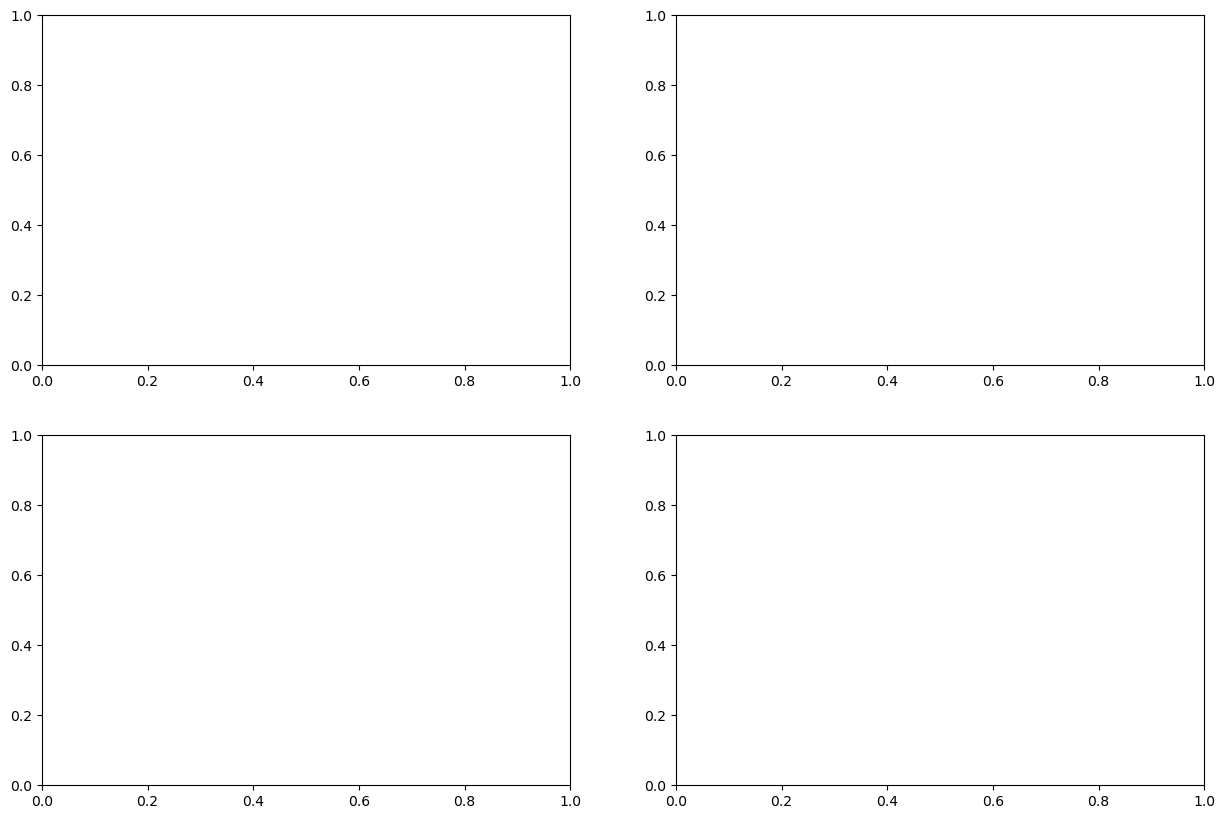

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")